## Calculate sidewalk width
Using centerline extraction (also called skeleton line, axis line, or medial line extraction)

In [1]:
# Add project src to path.
import set_path

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

import geopandas as gpd
from geopandas import GeoDataFrame
from centerline.geometry import Centerline

from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

import upcp.utils.bgt_utils as bgt_utils
import upcp.utils.las_utils as las_utils

import upc_sw.poly_utils as poly_utils

## Read the sidewalk and obstacle data

In [2]:
# Get dimensions of point cloud tile
tilecode = '2386_9702'
((x_min, y_max), (x_max, y_min)) = las_utils.get_bbox_from_tile_code(tilecode, padding=1)

# Get sidewalk polygons
bgt_road_file = '../datasets/bgt/bgt_voetpad.csv'
bgt_sidewalk_reader = bgt_utils.BGTPolyReader(bgt_file=bgt_road_file)

sidewalk_polygons = bgt_sidewalk_reader.filter_tile(
                            tilecode, bgt_types=['voetpad'],
                            padding=0, offset=0,
                            merge=False)

# Read sidewalk with obstacle data
df = gpd.read_file('../datasets/obstacles/sidewalks_merged.shp')
# A CRS tells Python how those coordinates relate to places on the Earth. Rijksdriehoek = epsg:28992
crs = 'epsg:28992' #local crs

(485099.0, 485151.0)

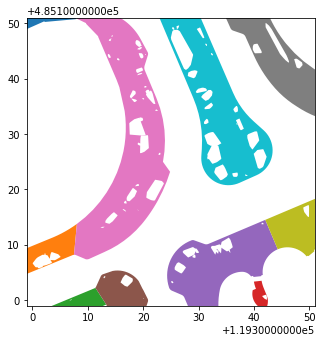

In [3]:
# Plot
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

df.plot(ax=ax, figsize=(4, 4), cmap='tab10')

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

## Merge the sidewalk polygons

In [4]:
df_dissolved = gpd.GeoDataFrame(geometry=gpd.GeoSeries([geom for geom in df.unary_union.geoms]))
df_exploded = gpd.GeoDataFrame(df_dissolved.geometry.explode(index_parts=True))

(485099.0, 485151.0)

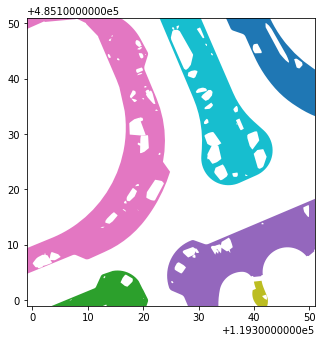

In [5]:
# Plot
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

df_exploded.plot(ax=ax, figsize=(4, 4), cmap='tab10')

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

## Calculate the centerlines

In [6]:
# if you get an error here, make sure you use tqdm>=4.61.2
df_exploded['centerlines'] = df_exploded.progress_apply(lambda row: Centerline(row.geometry), axis=1)
df_exploded = df_exploded.set_geometry('centerlines')

  0%|          | 0/6 [00:00<?, ?it/s]

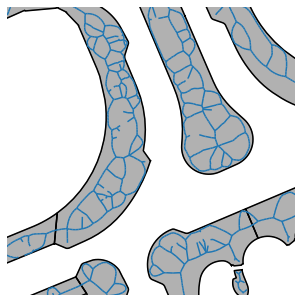

In [7]:
# Plot
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

for poly in sidewalk_polygons:
    x,y = poly.exterior.xy
    plt.fill(x, y, c="black", alpha=0.30)
    plt.plot(x, y, c="black")

df_exploded.plot(ax=ax, figsize=(4, 4))

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
plt.savefig('../media/examples/centerlines.png', bbox_inches='tight')

## Remove Short Line Ends

In [8]:
df_exploded['centerlines'] = df_exploded['centerlines'].progress_apply(poly_utils.linemerge)

  0%|          | 0/6 [00:00<?, ?it/s]

In [9]:
df_exploded['centerlines'] = df_exploded['centerlines'].progress_apply(poly_utils.remove_short_lines)

  0%|          | 0/6 [00:00<?, ?it/s]

In [10]:
df_exploded.head()

,,geometry,centerlines
0,0,"POLYGON ((119342.628 485151.589, 119342.967 48...","MULTILINESTRING ((119335.855 485159.369, 11933..."
1,0,"POLYGON ((119334.688 485062.826, 119345.855 48...","MULTILINESTRING ((119291.688 485092.700, 11929..."
2,0,"POLYGON ((119339.513 485104.270, 119339.409 48...","MULTILINESTRING ((119326.494 485107.853, 11932..."
3,0,"POLYGON ((119307.514 485108.208, 119307.462 48...","MULTILINESTRING ((119203.956 485068.109, 11920..."
4,0,"POLYGON ((119341.388 485103.522, 119341.403 48...","MULTILINESTRING ((119340.711 485101.113, 11934..."


(485099.0, 485151.0)

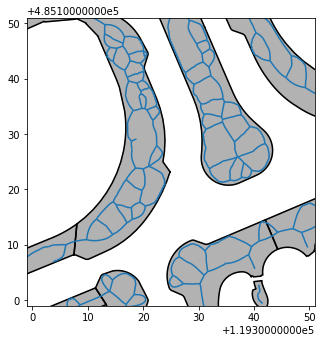

In [11]:
# Plot
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

for poly in sidewalk_polygons:
    x,y = poly.exterior.xy
    plt.fill(x, y, c="black", alpha=0.30)
    plt.plot(x, y, c="black")

df_exploded.plot(ax=ax, figsize=(4, 4))

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

## Get Sidewalk Widths

In [12]:
df_exploded['centerlines'] = df_exploded['centerlines'].progress_apply(lambda row: row.simplify(1, preserve_topology=True))

  0%|          | 0/6 [00:00<?, ?it/s]

In [13]:
df_exploded['segments'] = df_exploded['centerlines'].progress_apply(poly_utils.get_segments)
df_exploded.head(1)

  0%|          | 0/6 [00:00<?, ?it/s]

,,geometry,centerlines,segments
0,0,"POLYGON ((119342.628 485151.589, 119342.967 48...","MULTILINESTRING ((119335.855 485159.369, 11933...",[LINESTRING (119335.8553512936 485159.36855665...


In [14]:
df_exploded['avg_distances'] = df_exploded.progress_apply(lambda row: poly_utils.get_avg_distances(row), axis=1)
df_exploded.head(1)

  0%|          | 0/6 [00:00<?, ?it/s]

,,geometry,centerlines,segments,avg_distances
0,0,"POLYGON ((119342.628 485151.589, 119342.967 48...","MULTILINESTRING ((119335.855 485159.369, 11933...",[LINESTRING (119335.8553512936 485159.36855665...,"[1.7707866932268794, 3.4468430431485406, 3.802..."


In [15]:
data = {'geometry': [], 'width': []}

for i, row in df_exploded.iterrows():
    
    for segment in row.segments:
        data['geometry'].append(segment)
    
    for distance in row.avg_distances:
        data['width'].append(distance * 2)
        
df_segments = pd.DataFrame(data)
df_segments = GeoDataFrame(df_segments, crs=crs, geometry='geometry')
df_segments.head(1)

,geometry,width
0,"LINESTRING (119335.855 485159.369, 119338.831 ...",3.541573


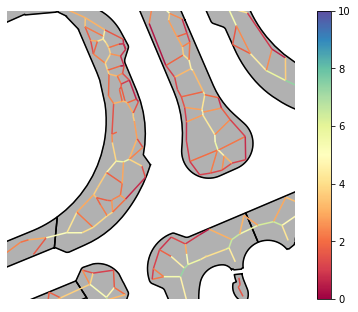

In [16]:
# Plot
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

for poly in sidewalk_polygons:
    x,y = poly.exterior.xy
    plt.fill(x, y, c="black", alpha=0.30)
    plt.plot(x, y, c="black")

df_segments.plot(ax=ax, figsize=(4, 4), column='width', cmap='Spectral', vmin=0, vmax=10, legend=True)
    
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
plt.savefig('../media/examples/sidewalk_width.png', bbox_inches='tight')

In [17]:
# Width in meters
df_segments['width'] = round(df_segments['width'] * 10) / 10
df_segments.head()

,geometry,width
0,"LINESTRING (119335.855 485159.369, 119338.831 ...",3.5
1,"LINESTRING (119335.855 485159.369, 119336.643 ...",6.9
2,"LINESTRING (119336.643 485156.639, 119338.614 ...",7.6
3,"LINESTRING (119338.614 485152.100, 119338.676 ...",7.5
4,"LINESTRING (119338.880 485151.563, 119338.676 ...",7.3
